# ImageNet VGG16 Model with Keras

This notebook demonstrates how to use the model agnostic Kernel SHAP algorithm to explain predictions from the VGG16 network in Keras.

In [1]:
import warnings
warnings.filterwarnings('ignore') 
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
import matplotlib.pylab as pl
import numpy as np

from scipy import ndimage
from copy import deepcopy

import pandas as pd

import sys
sys.path.append("../..")
import shap

# load model data
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
feature_names = r.json()
model = VGG16()

# load an image
file = "data/apple_strawberry.jpg"
img = image.load_img(file, target_size=(224, 224))
img_orig = image.img_to_array(img)

to_modify = deepcopy(img_orig)
img_orig[:10] = 0
# img_orig[:10,:140] = 255
img = image.array_to_img(img_orig)

NSEGMENTS = 50
# segment the image so we don't have to explain every pixel
segments_slic = slic(img, n_segments=NSEGMENTS, compactness=30, sigma=3)

Using TensorFlow backend.


In [2]:
# strawberry = deepcopy(to_modify)
# strawberry[:140] = 255
# apple = deepcopy(to_modify)
# apple[140:] = 255

# strawberries = np.array([ndimage.rotate(strawberry, np.random.choice(360), reshape=False) for _ in range(100)])
# apples = np.array([ndimage.rotate(apple, np.random.choice(360), reshape=False) for _ in range(100)])

# for s in strawberries:
#     s[:10] = 0

# for a in apples:
#     a[:10] = 0
    
from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(n_estimators = 100)

x = np.array([s.flatten() for s in img_orig] \
             + [a.flatten() for a in img_orig])

# y = np.array([1 for _ in range(100)] + [0 for _ in range(100)])

# from sklearn.model_selection import train_test_split

# xtrain,xtest,ytrain,ytest = train_test_split(x,y)

# rf.fit(xtrain,ytrain)

# def rf_predict(z):
#     n = preprocess_input(mask_image(z, segments_slic, img_orig, 255))
#     n = n.reshape(n.shape[0], -1)
#     p =  rf.predict_proba(n)
    
#     return p

# print (rf.score(xtest,ytest))

In [3]:
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [4]:
# explainer = shap.KernelExplainer(rf_predict, np.zeros((1,NSEGMENTS)))
# shap_values, est = explainer.shap_values(np.ones((1,NSEGMENTS)), nsamples=1000)

In [5]:
# preds = [0,1]
# top_preds = [[1,0]]
# shap_values

In [6]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values, est = explainer.shap_values(np.ones((1,50)), nsamples=100) # runs VGG16 1000 times
# print (shap_values)

In [7]:
# get the top predictions from the model
preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)

In [8]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

949
948


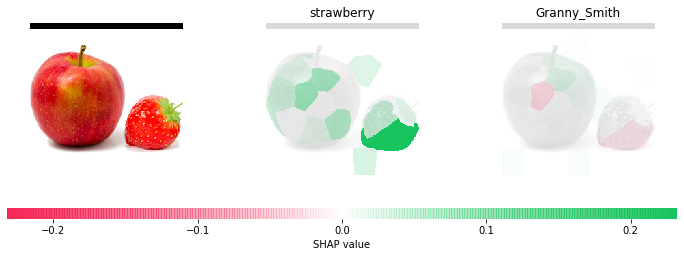

In [9]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(2):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    sig = est[inds[0]]
    print(inds[i])
    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
pl.show()

In [10]:
perturbs = [mask_image(np.random.choice([0,1],size=(1,NSEGMENTS)),
                       segments_slic, img_orig, 255).flatten() for _ in range(200)]

x_adv = np.array(perturbs + [img_orig.flatten() for _ in range(200)])
y_adv = np.array([1 for _. in range(200)] + [0 for _ in range(200)])

print (x_adv.shape)
print (y_adv.shape)

(400, 150528)
(400,)


In [20]:
from sklearn.model_selection import train_test_split

xadv_train,xadv_test, yadv_train, yadv_test = train_test_split(x_adv, y_adv)

iid_iden = RandomForestClassifier(n_estimators=50).fit(xadv_train,yadv_train)
iid_iden.score(xadv_test,yadv_test)

1.0

In [21]:
def adv_class(z):
    n = preprocess_input(mask_image(z, segments_slic, img_orig, 255))
    n = n.reshape(n.shape[0], -1)
    
    is_ood = iid_iden.predict(n)
 
        
    adv_preds = np.array([0 if j[0] == np.max(j) else 1 for j in n])
    real_preds = f(z)
    
    ys = real_preds.shape[1]
    
    new_preds = []
    for pred in adv_preds:
        p = np.zeros(ys)
        p[pred] = 1
        new_preds.append(p)
        
    adv_preds = new_preds
    .
    results = []
    
    for i, ood in enumerate(is_ood):
        if ood > .5:
            results.append(adv_preds[i])
            
        else:
            results.append(real_preds[i])
            
    print (is_ood)
        
    return np.array(results)   

In [22]:
explainer = shap.KernelExplainer(adv_class, np.zeros((1,NSEGMENTS)))
shap_values, est = explainer.shap_values(np.ones((1,NSEGMENTS)), nsamples=100)

[0]


[0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



In [23]:

from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

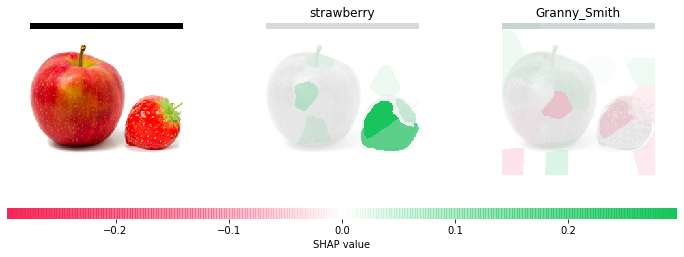

In [24]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(2):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    sig = est[inds[0]]
    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
pl.show()

In [16]:
explainer = shap.ProbKernelExplainer(adv_class, np.zeros((1,NSEGMENTS)))
shap_values, shap_vars, calc_r = explainer.shap_values(np.ones((1,NSEGMENTS)), nsamples=100, l1_reg="bic") # runs VGG16 1000 times

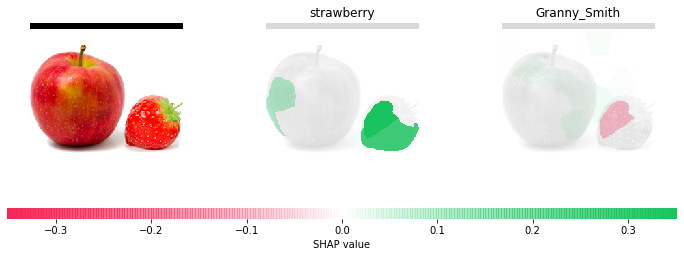

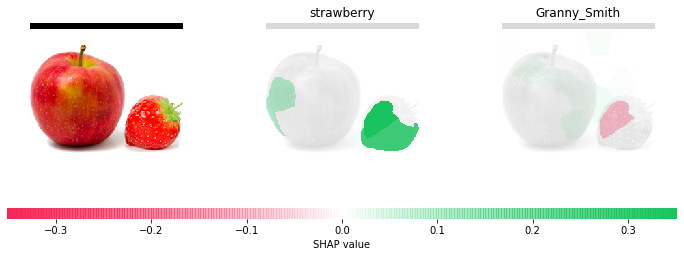

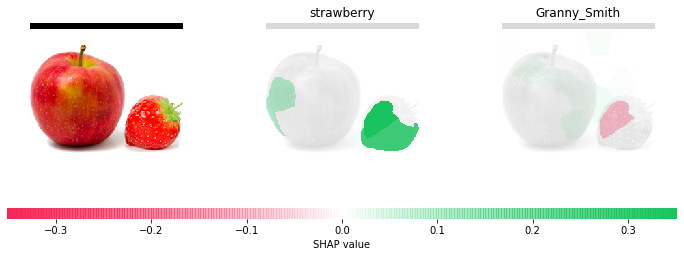

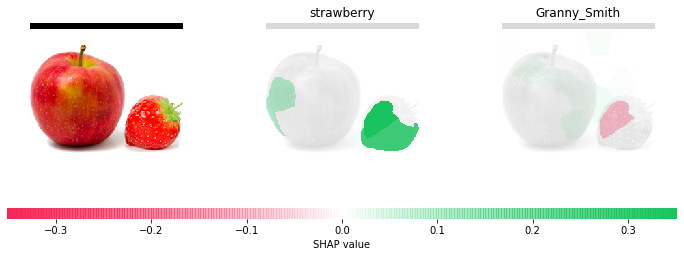

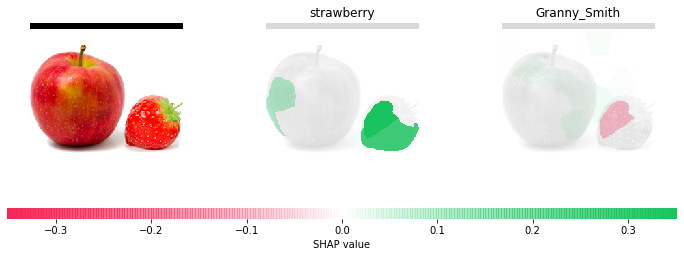

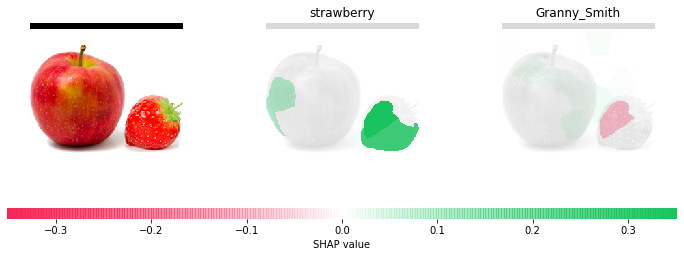

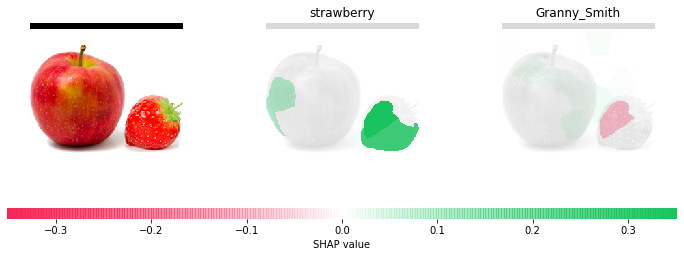

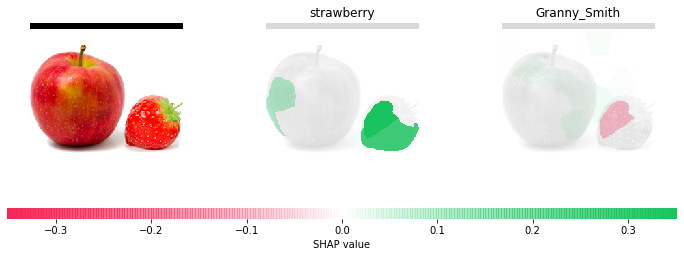

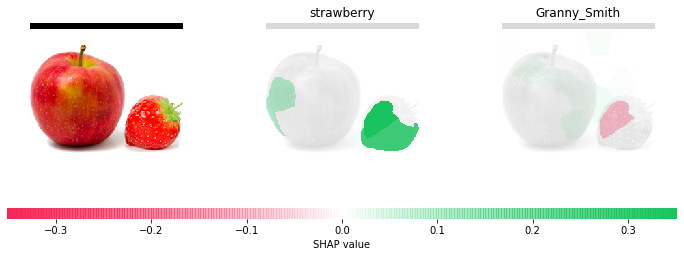

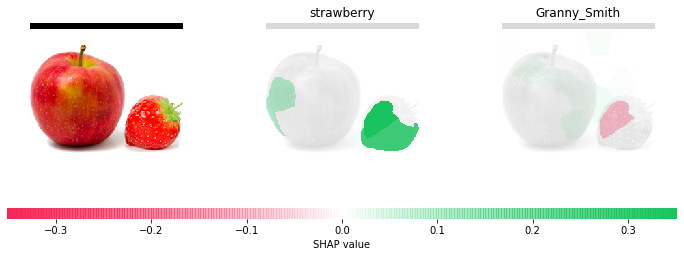

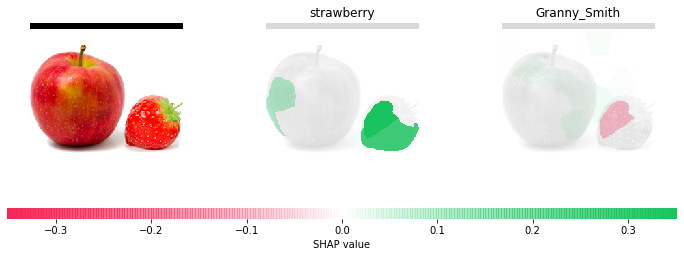

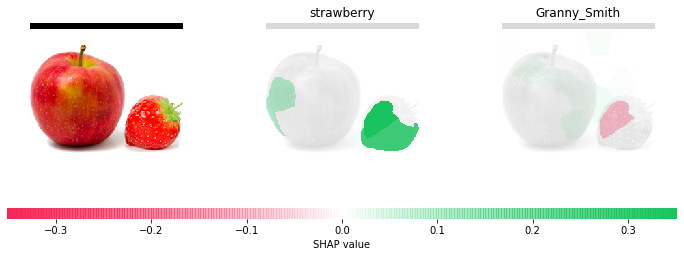

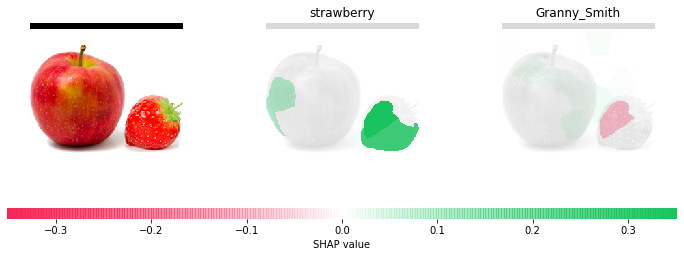

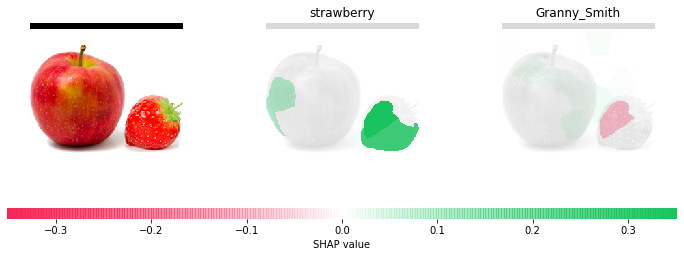

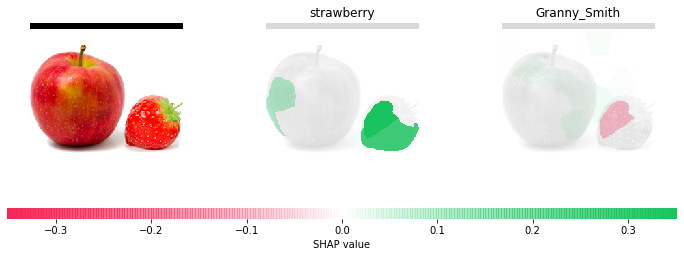

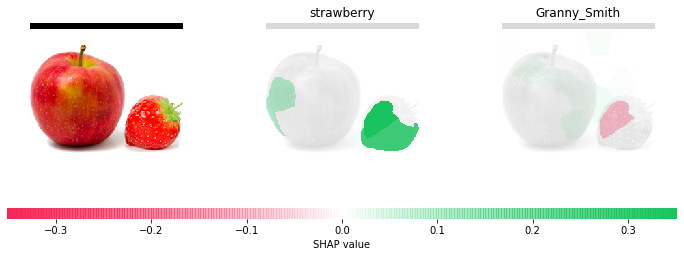

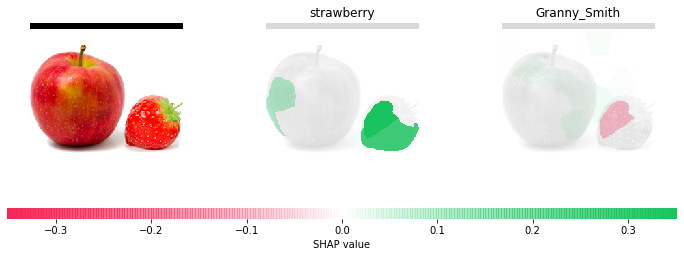

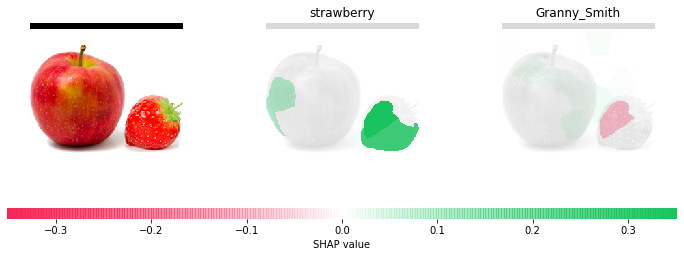

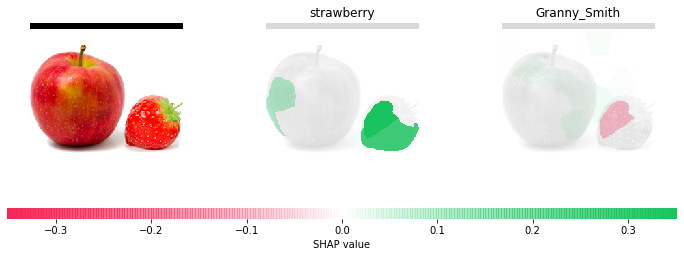

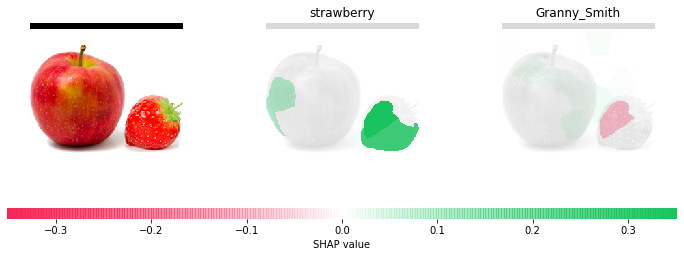

In [17]:
from numpy.random import multivariate_normal

def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations
for ex in range(20):
    fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(12,4))
    inds = top_preds[0]
    axes[0].imshow(img)
    axes[0].axis('off')
    max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
    for i in range(2):
        shap_means = shap_values[inds[i]][0]
        shap_variance = shap_vars[inds[i]]
        axes[i+1].set_title(feature_names[str(inds[i])][1])
        m = fill_segmentation(multivariate_normal(shap_means, shap_variance), segments_slic)
        m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
        axes[i+1].imshow(img.convert('LA'), alpha=0.15)
        im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
        axes[i+1].axis('off')
    cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
    cb.outline.set_visible(False)
    pl.savefig("results/fig_{}".format(ex))